In [1]:
import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from mordred import Calculator, descriptors

from tqdm import tqdm

from mordred import Calculator, descriptors

random_seed = 42

# Prepare data

In [60]:
df = (pd.read_csv('../data/crc_2.csv', sep=';'))
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

calc = Calculator(descriptors.AdjacencyMatrix.AdjacencyMatrix(type='VE1'))
df['VE1_A'] = df['Mol'].apply(lambda mol: calc(mol)['VE1_A'])
df['log_VE1_A'] = df['VE1_A'].apply(lambda x: math.log(x) if x > 0 else 0)

df['log_num_atoms'] = df['num_atoms'].apply((math.log))

df.head(2)

,name,boiling_point,SMILES,IUPAC_name,CID,molecular_formula,M1,M2,num_atoms,MW,...,delta_p,delta_bp,delta_w,delta_t,deviation,predicted_bp,Mol,VE1_A,log_VE1_A,log_num_atoms
0,Butane,-0.5,CCCC,butane,7843,C4H10,10,8,4,58.124,...,0,0.0,0,0.0,0.0,-0.5,<rdkit.Chem.rdchem.Mol object at 0x000002B1A0A...,1.946498,0.666032,1.386294
1,Dodecane,216.3,CCCCCCCCCCCC,dodecane,8182,C12H26,42,40,12,170.340,...,0,0.0,0,0.0,0.0,216.3,<rdkit.Chem.rdchem.Mol object at 0x000002B1A0A...,3.230323,1.172582,2.484907


In [62]:
df[['name', 'SMILES', 'num_atoms', 'boiling_point']].sort_values(by='num_atoms', ascending=True).head(10)

,name,SMILES,num_atoms,boiling_point
3,Ethane,CC,2,-88.60
2,Propane,CCC,3,-42.10
0,Butane,CCCC,4,-0.50
67,Isobutane,CC(C)C,4,-11.70
99,Pentane,CCCCC,5,36.06
9,"2,3-Dimethylbutane",CC(C)C(C)C,6,58.00
10,"2,2-Dimethylbutane",CCC(C)(C)C,6,49.70
66,Hexane,CCCCCC,6,68.72
84,3-Methylpentane,CCC(C)CC,6,63.30
83,2-Methylpentane,CCCC(C)C,6,60.21


In [12]:
df_sorted = df.sort_values(by='num_atoms')

split_index = int(len(df_sorted) * 0.85)

df_train = df_sorted.iloc[:split_index].reset_index(drop=True)
df_test = df_sorted.iloc[split_index:].reset_index(drop=True)

print("Train set size:", len(df_train))
print("Test set size:", len(df_test))

Train set size: 114
Test set size: 21


# VE1

## Linear regression

In [4]:
def evaluate_descriptor_LR(descriptor, df_train, df_test, plot=False):

    X_train = df_train[[descriptor]]
    y_train = df_train['boiling_point']
    X_test = df_test[[descriptor]]
    y_test = df_test['boiling_point']

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    if plot:
        y_pred_train = model.predict(X_train)

        # Plot true vs predicted
        plt.figure(figsize=(6, 6))
        plt.scatter(y_train, y_pred_train, alpha=0.7, label='Train', color='blue')
        plt.scatter(y_test, y_pred_test, alpha=0.7, label='Test', color='green')
        min_val = min(min(y_train), min(y_test))
        max_val = max(max(y_train), max(y_test))
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        plt.xlabel("True Boiling Point")
        plt.ylabel("Predicted Boiling Point")
        plt.title(f"True vs Predicted Boiling Point for {descriptor}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the regression line
        x_min = min(df_train[descriptor].min(), df_test[descriptor].min())
        x_max = max(df_train[descriptor].max(), df_test[descriptor].max())
        x_vals = np.linspace(x_min, x_max, 200).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[descriptor])
        y_vals = model.predict(x_vals_df)
        
        plt.figure(figsize=(6, 6))
        plt.scatter(X_train, y_train, color='blue', alpha=0.7, label='Train')
        plt.scatter(X_test, y_test, color='green', alpha=0.7, label='Test')
        plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Regression Line')

        plt.xlabel(descriptor)
        plt.ylabel("Boiling Point")
        plt.title(f"Regression Line for {descriptor}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

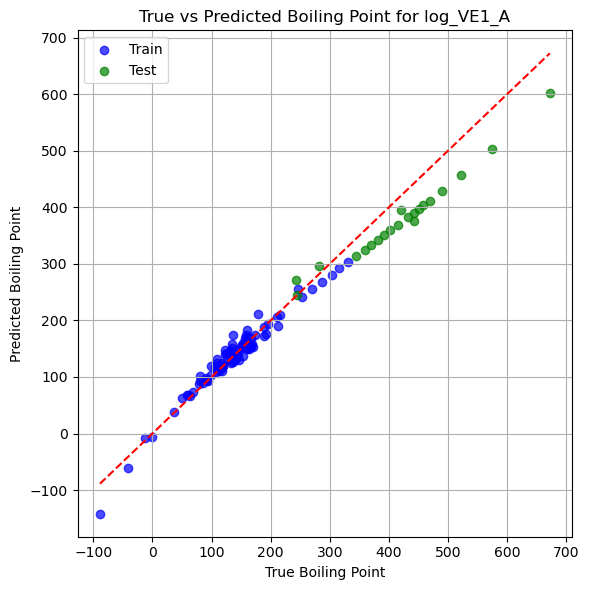

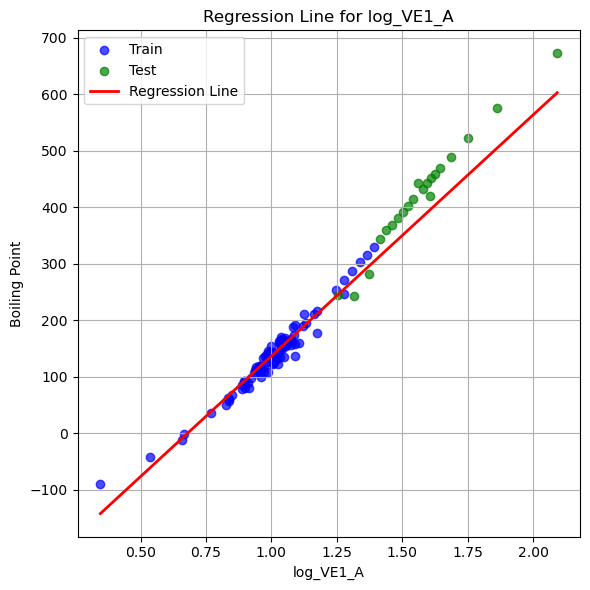

In [5]:
metrics_LR_VE1 = evaluate_descriptor_LR('log_VE1_A', df_train, df_test, plot=True)

# Polynomial fit

In [ ]:
def evaluate_descriptor_PF(descriptor, df_train, df_test, plot=False, degree=2):
    X_train = df_train[[descriptor]]
    y_train = df_train['boiling_point']
    X_test = df_test[[descriptor]]
    y_test = df_test['boiling_point']

    # Polynomial transformation
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    print(f"Model coefficients for {descriptor} (degree {degree}): {    }")
    print(f"Model intercept for {descriptor} (degree {degree}): {model.intercept_}")
    print(f"Equation: y = {model.intercept_:.2f} + " + " + ".join([f"{coef:.2f}*x^{i+1}" for i, coef in enumerate(model.coef_)]))

    y_pred_test = model.predict(X_test_poly)

    rmse = root_mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    if plot:
        y_pred_train = model.predict(X_train_poly)

        # Plot true vs predicted
        plt.figure(figsize=(6, 6))
        plt.scatter(y_train, y_pred_train, alpha=0.7, label='Train', color='blue')
        plt.scatter(y_test, y_pred_test, alpha=0.7, label='Test', color='green')
        min_val = min(min(y_train), min(y_test))
        max_val = max(max(y_train), max(y_test))
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        plt.xlabel("True Boiling Point")
        plt.ylabel("Predicted Boiling Point")
        plt.title(f"True vs Predicted Boiling Point for {descriptor} (Polynomial)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the regression curve
        x_min = min(df_train[descriptor].min(), df_test[descriptor].min())
        x_max = max(df_train[descriptor].max(), df_test[descriptor].max())
        x_vals = np.linspace(x_min, x_max, 200).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[descriptor])
        x_vals_poly = poly.transform(x_vals_df)
        y_vals = model.predict(x_vals_poly)

        plt.figure(figsize=(6, 6))

        train_color = '#4C72B0'
        val_color = '#DD8452'
        fit_color = '#333333'

        plt.scatter(X_train, y_train, label='Training data', color=train_color, s=50, alpha=0.8)
        plt.scatter(X_test, y_test, label='Test data', color=val_color, s=50, alpha=0.8)

        plt.plot(x_vals, y_vals, color=fit_color, linewidth=2, label='Polynomial Fit (deg 2)')


        plt.xlabel("VE1" if descriptor == 'VE1_A' else descriptor)
        plt.ylabel("Boiling point (°C)")
        # plt.title(f"Polynomial regression curve for {descriptor}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.savefig("../img/ood_alkanes_ve1.svg", format="svg")

        plt.show()

    return {'rmse': rmse, 'mae': mae, 'r2': r2}


Model coefficients for VE1_A (degree 2): [226.49705494 -11.70174739]
Model intercept for VE1_A (degree 2): -394.9114637970563
Equation: y = -394.91 + 226.50*x^1 + -11.70*x^2


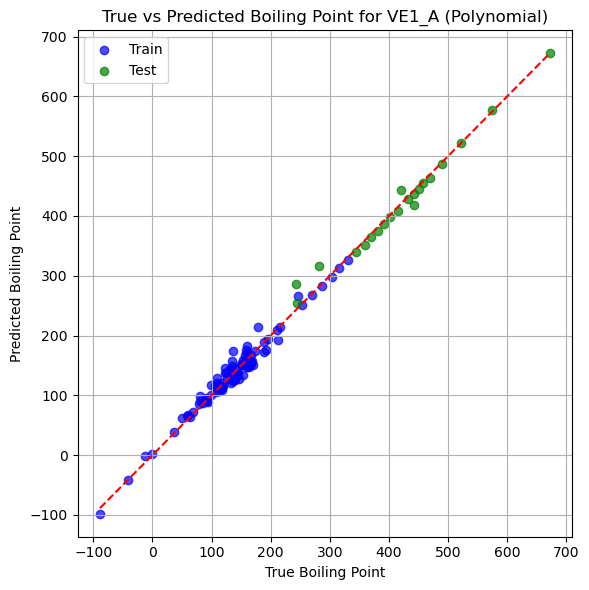

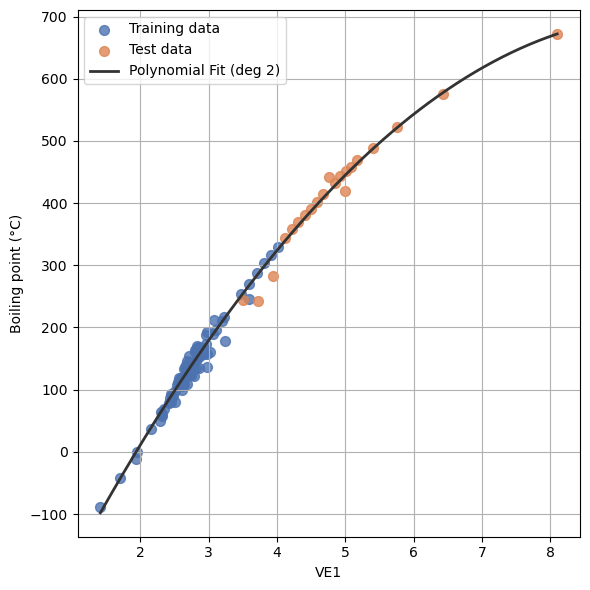

In [58]:
metrics_PF_VE1 = evaluate_descriptor_PF('VE1_A', df_train, df_test, plot=True, degree=2)

In [13]:
metrics_PF_VE1


{'rmse': 15.059047178231497,
 'mae': 9.806499579696357,
 'r2': 0.9767769569240782}

# Wiener's equation

In [25]:
df_train.columns

Index(['name', 'boiling_point', 'SMILES', 'IUPAC_name', 'CID',
       'molecular_formula', 'M1', 'M2', 'num_atoms', 'MW', 'InChIKey', 'W',
       'W_log', 'num_atoms_log', 'M1_log', 'polarity_number', 'n_isomer_p',
       'n_isomer_bp', 'n_isomer_w', 'delta_p', 'delta_bp', 'delta_w',
       'delta_t', 'deviation', 'predicted_bp', 'Mol', 'VE1_A', 'log_VE1_A',
       'log_num_atoms'],
      dtype='object')

In [53]:
rmse = root_mean_squared_error(df_test['boiling_point'], df_test['predicted_bp'])
mae = mean_absolute_error(df_test['boiling_point'], df_test['predicted_bp'])
r2 = r2_score(df_test['boiling_point'], df_test['predicted_bp'])

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

RMSE: 44.926, MAE: 17.603, R²: 0.793


In [30]:
df_test['bp_MAE'] = abs(df_test['boiling_point'] - df_test['predicted_bp'])

In [33]:
df_train['bp_MAE'] = abs(df_train['boiling_point'] - df_train['predicted_bp'])

In [41]:
df_test[['boiling_point', 'predicted_bp', 'name', 'SMILES', 'bp_MAE', 'MW']].sort_values(by='MW', ascending=False)

,boiling_point,predicted_bp,name,SMILES,bp_MAE,MW
20,672.0,672.000000,Octacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.000000,1124.176
19,575.0,575.000000,Pentacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.000000,703.366
18,522.0,522.000000,Tetracontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,563.096
17,489.0,489.000000,Pentatriacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,492.961
16,470.0,470.000000,Dotriacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,450.880
15,458.0,458.000000,Hentriacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,436.853
14,282.0,367.022893,11-Decylheneicosane,CCCCCCCCCCC(CCCCCCCCCC)CCCCCCCCCC,85.022893,436.853
13,451.0,451.000000,Triacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,422.826
12,420.0,397.648889,"2,6,10,15,19,23-Hexamethyltetracosane",CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C,22.351111,422.826
11,443.0,443.000000,Nonacosane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.000000,408.799


In [49]:
df_train[['boiling_point', 'predicted_bp', 'name', 'SMILES', 'bp_MAE', 'MW']].sort_values(by='MW', ascending=False).head(15)

,boiling_point,predicted_bp,name,SMILES,bp_MAE,MW
113,330.0,330.000000,Nonadecane,CCCCCCCCCCCCCCCCCCC,0.000000,268.529
112,316.0,316.000000,Octadecane,CCCCCCCCCCCCCCCCCC,0.000000,254.502
111,303.0,303.000000,Heptadecane,CCCCCCCCCCCCCCCCC,0.000000,240.475
109,246.0,222.243750,"2,2,4,4,6,8,8-Heptamethylnonane",CC(CC(C)(C)C)CC(C)(C)CC(C)(C)C,23.756250,226.448
110,286.9,286.900000,Hexadecane,CCCCCCCCCCCCCCCC,0.000000,226.448
108,270.6,270.600000,Pentadecane,CCCCCCCCCCCCCCC,0.000000,212.421
107,253.5,253.500000,Tetradecane,CCCCCCCCCCCCCC,0.000000,198.394
104,211.0,210.175000,2-Methylundecane,CCCCCCCCCC(C)C,0.825000,170.340
106,178.0,170.758333,"2,2,4,6,6-Pentamethylheptane",CC(CC(C)(C)C)CC(C)(C)C,7.241667,170.340
105,212.0,210.911111,3-Methylundecane,CCCCCCCCC(C)CC,1.088889,170.340


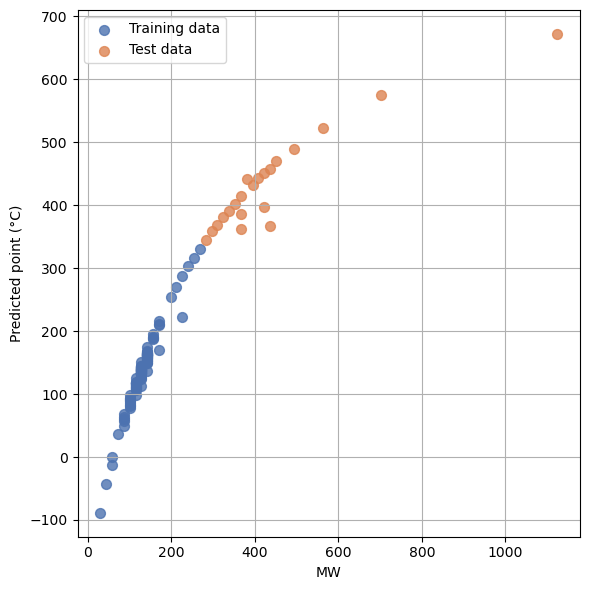

In [ ]:
# Plot the regression curve
x_min = min(df_train['MW'].min(), df_test['MW'].min())
x_max = max(df_train['MW'].max(), df_test['MW'].max())

plt.figure(figsize=(6, 6))

train_color = '#4C72B0'
val_color = '#DD8452'
fit_color = '#333333'

plt.scatter(df_train['MW'], df_train['predicted_bp'], label='Training data', color=train_color, s=50, alpha=0.8)
plt.scatter(df_test['MW'], df_test['predicted_bp'], label='Test data', color=val_color, s=50, alpha=0.8)


plt.xlabel("MW")
plt.ylabel("Predicted point (°C)")
# plt.title(f"Polynomial regression curve for {descriptor}")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../img/ood_alkanes_ve1.svg", format="svg")

plt.show()

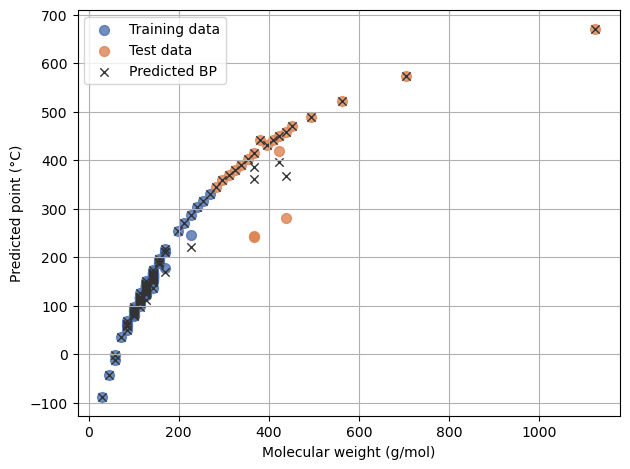

In [50]:
import numpy as np

# Sort by MW for a smooth curve
sorted_df = df.sort_values(by='MW')

# Plot original data
train_color = '#4C72B0'
val_color = '#DD8452'
fit_color = '#333333'

plt.scatter(df_train['MW'], df_train['boiling_point'], label='Training data', color=train_color, s=50, alpha=0.8)
plt.scatter(df_test['MW'], df_test['boiling_point'], label='Test data', color=val_color, s=50, alpha=0.8)

# Plot the curve
plt.scatter(sorted_df['MW'], sorted_df['predicted_bp'], label='Predicted BP', color=fit_color, linewidth=1, marker='x')

plt.xlabel("Molecular weight (g/mol)")
plt.ylabel("Predicted point (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../img/ood_alkanes_WEQ.svg", format="svg")
plt.show()


# Atom count

In [52]:
metrics_PF_num_atoms


{'rmse': 82.24958400704817,
 'mae': 49.390571903435294,
 'r2': 0.3072260318361122}

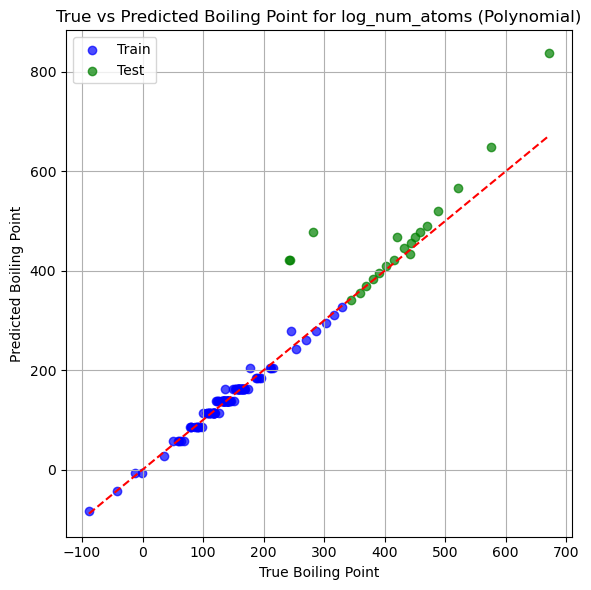

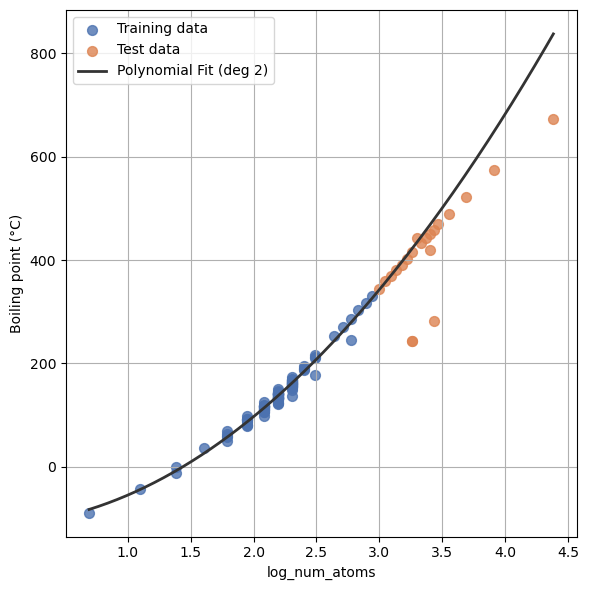

In [51]:
metrics_PF_num_atoms = evaluate_descriptor_PF('log_num_atoms', df_train, df_test, plot=True, degree=2)